# 06: M2/S2 - Supervised Classification (Sentence Level)

**Cíl:** Natrénovat klasifikátory na úrovni celých vět.
**Hypotéza:** Věta nese více kontextu než samotné slovo. Funguje lépe průměr všech tokenů (**Mean Pooling**) nebo speciální token (**[CLS]**)?

**Scénáře:**
* **S2a - Gold Balanced:** Trénink na Gold datech (undersampling L0 na 1:1).
* **S2b - Hybrid:** Trénink na mixu Gold (L0) + Silver (L1).

**Pooling Metody:**
* **Mean:** Průměr embeddingů všech slov ve větě.
* **CLS:** Embedding speciálního tokenu [CLS] (reprezentace celé sekvence dle BERTa).

## 1. Setup & Imports

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import logging
from pathlib import Path
import os
from itables import show

from sklearn.metrics import classification_report

# Auto-reload modules for development
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add src to path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)


# Vlastní moduly
import config
import data_splitting
import models
import evaluation
import visualization

# Logging setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Nastavení vizualizace
visualization.setup_style()

print(f"✅ Setup complete. Results dir: {config.RESULTS_DIR}")

⚙️ Configuration loaded. Device: cpu


2026-02-25 13:24:55,098 - INFO - 🎨 Visualization style set: whitegrid


✅ Setup complete. Results dir: C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\results


## 2. Data Check
Ověříme počty vět pro jednotlivé scénáře.

In [3]:
SCENARIOS_TO_CHECK = ['baseline', 'hybrid']
POOLING = 'mean' # Počty jsou stejné pro mean i cls, liší se jen dimenze X

print(f"{'='*80}")
print(f"📊 DATA CHECK REPORT (M2/S2 - Sentence Level)")
print(f"{'='*80}")

for scenario in SCENARIOS_TO_CHECK:
    print(f"\n🔹 SCÉNÁŘ: {scenario.upper()}")
    try:
        data = data_splitting.get_train_val_test_splits(
            scenario=scenario,
            level='sentence',
            pooling=POOLING,
            random_state=42
        )
        
        def print_stats(name, y):
            n_l0, n_l1 = np.sum(y == 0), np.sum(y == 1)
            ratio = n_l0 / n_l1 if n_l1 > 0 else 0
            print(f"   {name:<6} | Total: {len(y):<5} | L0: {n_l0:<4} | L1: {n_l1:<4} | Ratio: {ratio:.1f}:1")

        print_stats("TRAIN", data['y_train'])
        print_stats("VAL",   data['y_val'])
        print_stats("TEST",  data['y_test'])
        
    except Exception as e:
        print(f"   ❌ Chyba: {e}")

2026-02-25 13:24:55,282 - INFO - 📊 Preparing scenario: baseline (sentence level, aggressive filter)


📊 DATA CHECK REPORT (M2/S2 - Sentence Level)

🔹 SCÉNÁŘ: BASELINE


2026-02-25 13:24:55,373 - INFO - ✅ Loaded 1560 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\gold_sentences.pkl
2026-02-25 13:24:55,651 - INFO - ✅ Loaded 5709 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\silver_sentences.pkl
2026-02-25 13:24:55,667 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-25 13:24:55,681 - INFO - ✅ Document-level split completed:
2026-02-25 13:24:55,682 - INFO -    Train: 376 docs, 376 samples
2026-02-25 13:24:55,683 - INFO -    Val:   41 docs, 41 samples
2026-02-25 13:24:55,684 - INFO -    Test:  103 docs, 103 samples
2026-02-25 13:24:55,686 - INFO -    ✓ No document leakage detected between splits
2026-02-25 13:24:55,687 - INFO - ✅ Scenario data prepared:
2026-02-25 13:24:55,689 - INFO -    Train: 376 samples (L0: 136, L1: 240)
2026-02-25 13:24:55,691 - INFO -    Val:   41 samples (L0: 15, L1: 26)
2026-02-25 13:24:55,692 - INFO -    Test: 

   TRAIN  | Total: 376   | L0: 136  | L1: 240  | Ratio: 0.6:1
   VAL    | Total: 41    | L0: 15   | L1: 26   | Ratio: 0.6:1
   TEST   | Total: 103   | L0: 37   | L1: 66   | Ratio: 0.6:1

🔹 SCÉNÁŘ: HYBRID


2026-02-25 13:24:56,034 - INFO - ✅ Loaded 5709 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\silver_sentences.pkl
2026-02-25 13:24:56,073 - INFO - Splitting 1472 documents: 294 test, 117 val, 1061 train
2026-02-25 13:24:56,084 - INFO - ✅ Document-level split completed:
2026-02-25 13:24:56,085 - INFO -    Train: 1062 docs, 1062 samples
2026-02-25 13:24:56,086 - INFO -    Val:   117 docs, 117 samples
2026-02-25 13:24:56,086 - INFO -    Test:  293 docs, 293 samples
2026-02-25 13:24:56,088 - INFO -    ✓ No document leakage detected between splits
2026-02-25 13:24:56,089 - INFO - ✅ Scenario data prepared:
2026-02-25 13:24:56,090 - INFO -    Train: 1062 samples (L0: 136, L1: 926)
2026-02-25 13:24:56,092 - INFO -    Val:   117 samples (L0: 15, L1: 102)
2026-02-25 13:24:56,093 - INFO -    Test:  293 samples (L0: 37, L1: 256)


   TRAIN  | Total: 1062  | L0: 136  | L1: 926  | Ratio: 0.1:1
   VAL    | Total: 117   | L0: 15   | L1: 102  | Ratio: 0.1:1
   TEST   | Total: 293   | L0: 37   | L1: 256  | Ratio: 0.1:1


## 3. Experiment Loop (Pooling & Scenarios)
Trénujeme kombinace: **Scénář x Pooling x Model**.

**Scénáře:**
* **S2a:** Baseline (Gold) + Manual Undersampling
* **S2b:** Hybrid (Gold L0 + Silver L1)

**Pooling:** `mean` vs `cls`

In [4]:
# Cesta pro výsledky
RESULTS_PATH = config.RESULTS_DIR / "M2_S2_experiment_results_v1.csv"

# Definice experimentů (Scénáře)
SCENARIOS = [
    {'id': 'S2a', 'name': 'Gold Balanced', 'scenario': 'baseline', 'balance_train': True},
    {'id': 'S2b', 'name': 'Hybrid (G+S)',  'scenario': 'hybrid',   'balance_train': False}, # Hybrid je už balanced z modulu
]

POOLING_METHODS = ['mean', 'cls']

# MODELS_TO_TEST = ['LogReg', 'SVM (RBF)'] # Pro rychlost. SVM (Lin) můžeš přidat.          # Pro krátký test
MODELS_TO_TEST = ["LogReg", "SVM (RBF)", "XGBoost", "Dummy", "SVM (Lin)", "NaiveBayes", "RandForest"]

if models.XGBOOST_AVAILABLE:
    MODELS_TO_TEST.append('XGBoost')


In [5]:
results = []
best_f1 = 0.0
best_run = None

print(f"🚀 STARTING SENTENCE LEVEL EXPERIMENTS (All Metrics: P/R/F1/AUC)...")
print(f"💾 Results path: {RESULTS_PATH}")

for pooling in POOLING_METHODS:
    print(f"\n{'#'*60}")
    print(f"🌊 POOLING METHOD: {pooling.upper()}")
    print(f"{'#'*60}")
    
    for exp in SCENARIOS:
        print(f"\n   🧪 SCENARIO: {exp['id']} - {exp['name']}")
        
        try:
            # 1. Načtení dat
            data = data_splitting.get_train_val_test_splits(
                scenario=exp['scenario'],
                level='sentence',
                pooling=pooling,
                random_state=42
            )
            
            X_train, y_train = data['X_train'], data['y_train']
            X_val, y_val     = data['X_val'], data['y_val']
            X_test, y_test   = data['X_test'], data['y_test']
            
            print(f"      📊 Train Size: {X_train.shape[0]} (L0: {sum(y_train==0)}, L1: {sum(y_train==1)})")

            # 2. Trénink Modelů
            for model_name in MODELS_TO_TEST:
                print(f"      ⚙️ {model_name}...")
                
                try:
                    clf = models.get_supervised_model(model_name, random_state=42)
                    clf.fit(X_train, y_train)
                    
                    # Získání skóre
                    if hasattr(clf, "predict_proba"):
                        s_train = clf.predict_proba(X_train)[:, 1]
                        s_val   = clf.predict_proba(X_val)[:, 1]
                        s_test  = clf.predict_proba(X_test)[:, 1]
                    else:
                        s_train = clf.decision_function(X_train)
                        s_val   = clf.decision_function(X_val)
                        s_test  = clf.decision_function(X_test)
                    
                    # Threshold z Val
                    threshold, _ = evaluation.find_optimal_threshold(y_val, s_val, metric='f1')
                    
                    # Výpočet metrik pro VŠECHNY sady
                    m_train = evaluation.calculate_metrics(y_train, (s_train > threshold).astype(int), s_train)
                    m_val   = evaluation.calculate_metrics(y_val, (s_val > threshold).astype(int), s_val)
                    m_test  = evaluation.calculate_metrics(y_test, (s_test > threshold).astype(int), s_test)
                    
                    # Log (Ukládáme komplet všechno)
                    res = {
                        'id': exp['id'],
                        'scenario': exp['scenario'],
                        'scenario_name': exp['name'],
                        'pooling': pooling,
                        'model': model_name,
                        'threshold': threshold,
                        
                        # Train Metrics
                        'train_f1': m_train['f1'], 'train_auprc': m_train['avg_precision'], 'train_roc_auc': m_train['roc_auc'],
                        'train_prec': m_train['precision'], 'train_rec': m_train['recall'], # <--- NOVÉ
                        
                        # Val Metrics
                        'val_f1': m_val['f1'],     'val_auprc': m_val['avg_precision'],     'val_roc_auc': m_val['roc_auc'],
                        'val_prec': m_val['precision'], 'val_rec': m_val['recall'],         # <--- NOVÉ
                        
                        # Test Metrics
                        'test_f1': m_test['f1'],   'test_auprc': m_test['avg_precision'],   'test_roc_auc': m_test['roc_auc'],
                        'test_prec': m_test['precision'], 'test_rec': m_test['recall']      # <--- NOVÉ
                    }
                    results.append(res)
                    pd.DataFrame(results).to_csv(RESULTS_PATH, index=False)
                    
                    # Best Run Check (Stále podle F1 na testu)
                    if m_test['f1'] > best_f1:
                        best_f1 = m_test['f1']
                        best_run = {
                            'info': res,
                            'model': clf,
                            'data': data,
                            'scores_test': s_test,
                            'y_test': y_test
                        }
                        
                except Exception as e:
                    print(f"      ❌ Error {model_name}: {e}")
                    
        except Exception as e:
            print(f"   ❌ Error loading data: {e}")

print("\n✅ All experiments finished.")

2026-02-25 13:24:56,278 - INFO - 📊 Preparing scenario: baseline (sentence level, aggressive filter)


🚀 STARTING SENTENCE LEVEL EXPERIMENTS (All Metrics: P/R/F1/AUC)...
💾 Results path: C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\results\M2_S2_experiment_results_v1.csv

############################################################
🌊 POOLING METHOD: MEAN
############################################################

   🧪 SCENARIO: S2a - Gold Balanced


2026-02-25 13:24:56,350 - INFO - ✅ Loaded 1560 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\gold_sentences.pkl
2026-02-25 13:24:56,610 - INFO - ✅ Loaded 5709 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\silver_sentences.pkl
2026-02-25 13:24:56,614 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-25 13:24:56,620 - INFO - ✅ Document-level split completed:
2026-02-25 13:24:56,621 - INFO -    Train: 376 docs, 376 samples
2026-02-25 13:24:56,622 - INFO -    Val:   41 docs, 41 samples
2026-02-25 13:24:56,623 - INFO -    Test:  103 docs, 103 samples
2026-02-25 13:24:56,624 - INFO -    ✓ No document leakage detected between splits
2026-02-25 13:24:56,625 - INFO - ✅ Scenario data prepared:
2026-02-25 13:24:56,627 - INFO -    Train: 376 samples (L0: 136, L1: 240)
2026-02-25 13:24:56,629 - INFO -    Val:   41 samples (L0: 15, L1: 26)
2026-02-25 13:24:56,630 - INFO -    Test: 

      📊 Train Size: 376 (L0: 136, L1: 240)
      ⚙️ LogReg...
      ⚙️ SVM (RBF)...
      ⚙️ XGBoost...
      ⚙️ Dummy...
      ⚙️ SVM (Lin)...
      ⚙️ NaiveBayes...
      ⚙️ RandForest...
      ⚙️ XGBoost...


2026-02-25 13:24:59,825 - INFO - 📊 Preparing scenario: hybrid (sentence level, aggressive filter)
2026-02-25 13:24:59,885 - INFO - ✅ Loaded 1560 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\gold_sentences.pkl



   🧪 SCENARIO: S2b - Hybrid (G+S)


2026-02-25 13:25:00,147 - INFO - ✅ Loaded 5709 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\silver_sentences.pkl
2026-02-25 13:25:00,155 - INFO - Splitting 1472 documents: 294 test, 117 val, 1061 train
2026-02-25 13:25:00,161 - INFO - ✅ Document-level split completed:
2026-02-25 13:25:00,163 - INFO -    Train: 1062 docs, 1062 samples
2026-02-25 13:25:00,164 - INFO -    Val:   117 docs, 117 samples
2026-02-25 13:25:00,166 - INFO -    Test:  293 docs, 293 samples
2026-02-25 13:25:00,168 - INFO -    ✓ No document leakage detected between splits
2026-02-25 13:25:00,169 - INFO - ✅ Scenario data prepared:
2026-02-25 13:25:00,170 - INFO -    Train: 1062 samples (L0: 136, L1: 926)
2026-02-25 13:25:00,172 - INFO -    Val:   117 samples (L0: 15, L1: 102)
2026-02-25 13:25:00,173 - INFO -    Test:  293 samples (L0: 37, L1: 256)


      📊 Train Size: 1062 (L0: 136, L1: 926)
      ⚙️ LogReg...
      ⚙️ SVM (RBF)...
      ⚙️ XGBoost...
      ⚙️ Dummy...
      ⚙️ SVM (Lin)...
      ⚙️ NaiveBayes...
      ⚙️ RandForest...
      ⚙️ XGBoost...


2026-02-25 13:25:05,630 - INFO - 📊 Preparing scenario: baseline (sentence level, aggressive filter)
2026-02-25 13:25:05,691 - INFO - ✅ Loaded 1560 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\gold_sentences.pkl



############################################################
🌊 POOLING METHOD: CLS
############################################################

   🧪 SCENARIO: S2a - Gold Balanced


2026-02-25 13:25:05,917 - INFO - ✅ Loaded 5709 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\silver_sentences.pkl
2026-02-25 13:25:05,920 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-25 13:25:05,925 - INFO - ✅ Document-level split completed:
2026-02-25 13:25:05,925 - INFO -    Train: 376 docs, 376 samples
2026-02-25 13:25:05,927 - INFO -    Val:   41 docs, 41 samples
2026-02-25 13:25:05,927 - INFO -    Test:  103 docs, 103 samples
2026-02-25 13:25:05,929 - INFO -    ✓ No document leakage detected between splits
2026-02-25 13:25:05,930 - INFO - ✅ Scenario data prepared:
2026-02-25 13:25:05,931 - INFO -    Train: 376 samples (L0: 136, L1: 240)
2026-02-25 13:25:05,932 - INFO -    Val:   41 samples (L0: 15, L1: 26)
2026-02-25 13:25:05,933 - INFO -    Test:  103 samples (L0: 37, L1: 66)


      📊 Train Size: 376 (L0: 136, L1: 240)
      ⚙️ LogReg...
      ⚙️ SVM (RBF)...
      ⚙️ XGBoost...
      ⚙️ Dummy...
      ⚙️ SVM (Lin)...
      ⚙️ NaiveBayes...
      ⚙️ RandForest...
      ⚙️ XGBoost...


2026-02-25 13:25:09,210 - INFO - 📊 Preparing scenario: hybrid (sentence level, aggressive filter)
2026-02-25 13:25:09,271 - INFO - ✅ Loaded 1560 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\gold_sentences.pkl



   🧪 SCENARIO: S2b - Hybrid (G+S)


2026-02-25 13:25:09,832 - INFO - ✅ Loaded 5709 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\silver_sentences.pkl
2026-02-25 13:25:09,840 - INFO - Splitting 1472 documents: 294 test, 117 val, 1061 train
2026-02-25 13:25:09,846 - INFO - ✅ Document-level split completed:
2026-02-25 13:25:09,847 - INFO -    Train: 1062 docs, 1062 samples
2026-02-25 13:25:09,849 - INFO -    Val:   117 docs, 117 samples
2026-02-25 13:25:09,851 - INFO -    Test:  293 docs, 293 samples
2026-02-25 13:25:09,854 - INFO -    ✓ No document leakage detected between splits
2026-02-25 13:25:09,855 - INFO - ✅ Scenario data prepared:
2026-02-25 13:25:09,856 - INFO -    Train: 1062 samples (L0: 136, L1: 926)
2026-02-25 13:25:09,857 - INFO -    Val:   117 samples (L0: 15, L1: 102)
2026-02-25 13:25:09,859 - INFO -    Test:  293 samples (L0: 37, L1: 256)


      📊 Train Size: 1062 (L0: 136, L1: 926)
      ⚙️ LogReg...
      ⚙️ SVM (RBF)...
      ⚙️ XGBoost...
      ⚙️ Dummy...
      ⚙️ SVM (Lin)...
      ⚙️ NaiveBayes...
      ⚙️ RandForest...
      ⚙️ XGBoost...

✅ All experiments finished.


## 4. Results Overview
Srovnání vlivu Poolingu a Scénářů.

📊 SROVNÁNÍ AUPRC (Pooling x Scenario):



📊 DETAILNÍ GRAFY: MEAN vs CLS (Train vs Test)
   Generating plot for: AUPRC...


2026-02-25 13:25:17,004 - INFO - 💾 Saved C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\results\M2_S2_Pooling_Breakdown_AUPRC.png


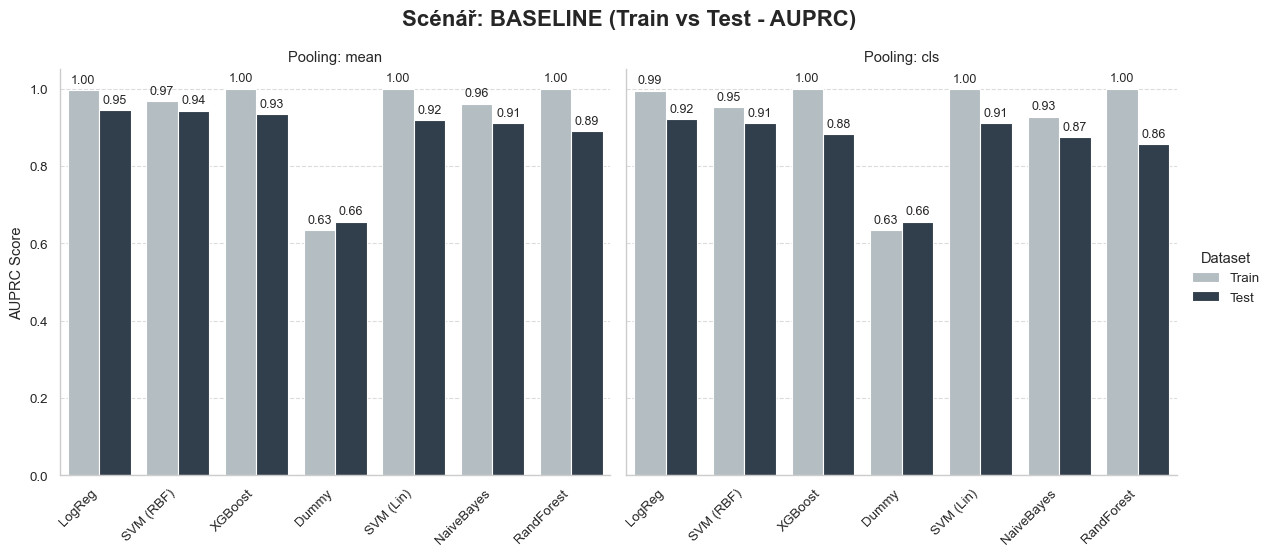

2026-02-25 13:25:18,164 - INFO - 💾 Saved C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\results\M2_S2_Pooling_Breakdown_AUPRC.png


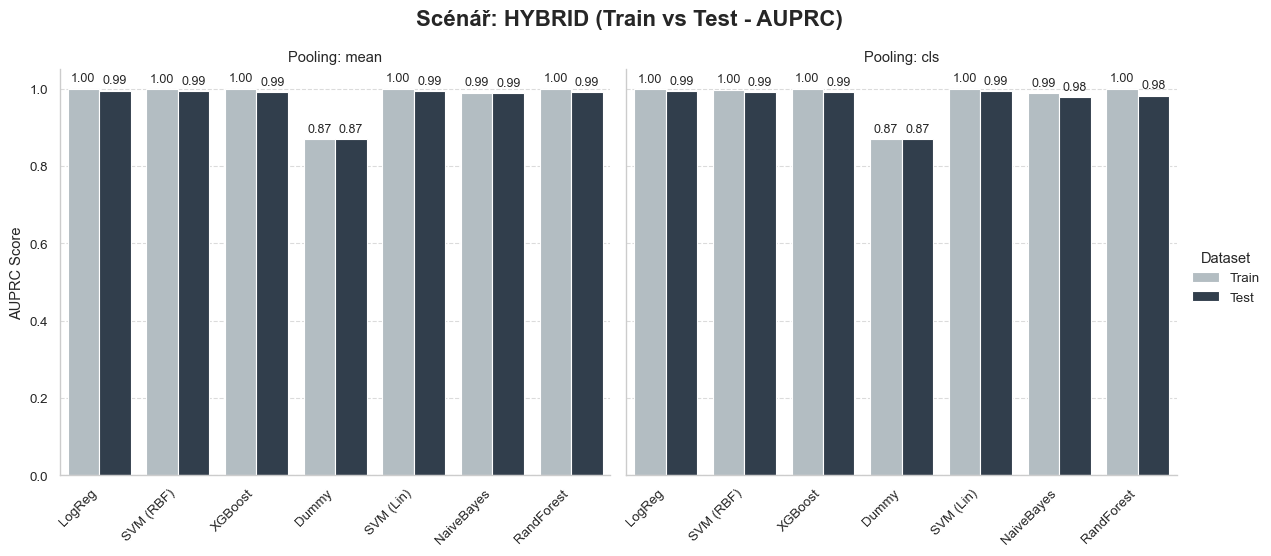

   Generating plot for: F1...


2026-02-25 13:25:19,312 - INFO - 💾 Saved C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\results\M2_S2_Pooling_Breakdown_F1.png


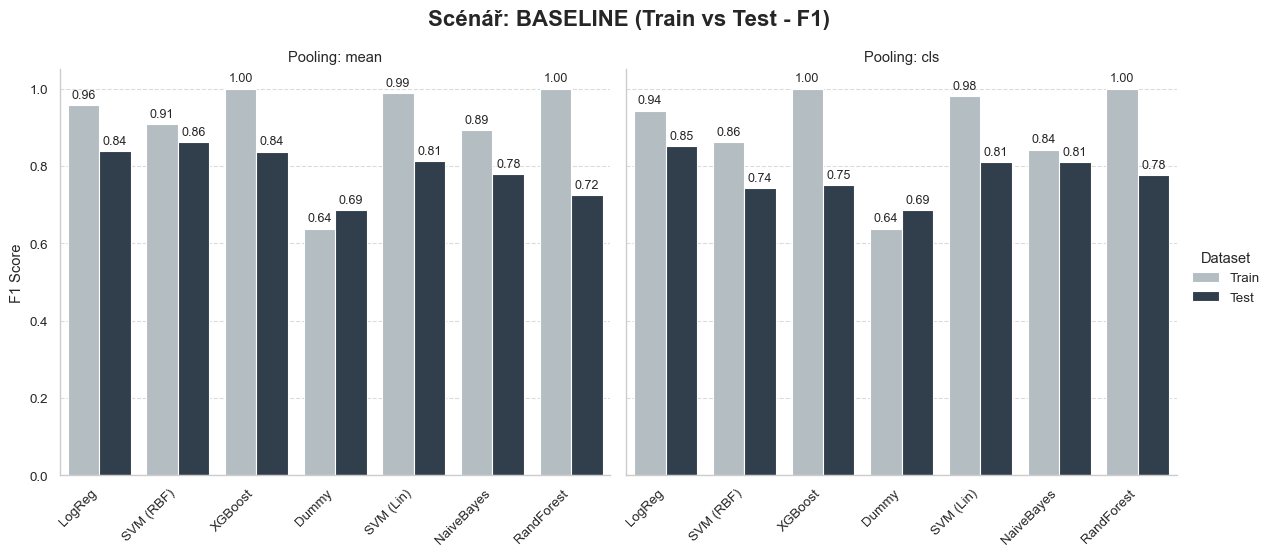

2026-02-25 13:25:20,430 - INFO - 💾 Saved C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\results\M2_S2_Pooling_Breakdown_F1.png


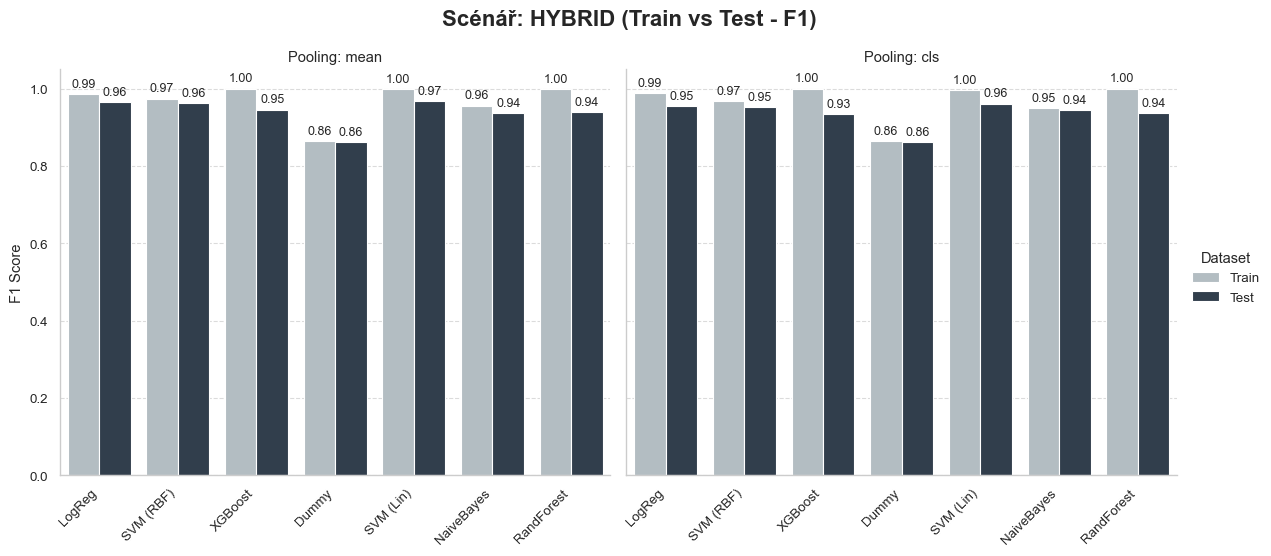


✅ Vizualizace hotova.


In [6]:
# =============================================================================
# 4. RESULTS OVERVIEW
# =============================================================================

# Načtení výsledků
if RESULTS_PATH.exists():
    df_results = pd.read_csv(RESULTS_PATH)
else:
    df_results = pd.DataFrame(results)

# -----------------------------------------------------------------------------
# A) PIVOT TABLE (Tabulka výsledků)
# -----------------------------------------------------------------------------
print("📊 SROVNÁNÍ AUPRC (Pooling x Scenario):")

pivot = df_results.pivot_table(
    values='test_auprc', 
    index='model',        
    columns=['pooling', 'scenario_name'], # Vytvoří MultiIndex ve sloupcích
    aggfunc='max'
)

# ✅ OPRAVA SORTINGU PRO MULTIINDEX
# Vypočítáme průměr pro každý řádek (model) bokem
mean_scores = pivot.mean(axis=1)
# Získáme seřazený seznam modelů
sorted_models = mean_scores.sort_values(ascending=False).index
# Přeřadíme tabulku podle tohoto seznamu
pivot = pivot.reindex(sorted_models)

# Zobrazíme (bez sloupce mean, ten byl jen pro řazení)
display(pivot.style.background_gradient(cmap='Blues', axis=None).format("{:.4f}"))

# -----------------------------------------------------------------------------
# B) VIZUALIZACE (Pooling Breakdown)
# -----------------------------------------------------------------------------
print("\n📊 DETAILNÍ GRAFY: MEAN vs CLS (Train vs Test)")

# Příprava dat (kopie)
df_viz = df_results.copy()

# Seznam metrik, které chceme vykreslit
metrics_to_plot = ['auprc', 'f1',] 

for m in metrics_to_plot:
    # Kontrola, zda máme data (např. 'test_prec')
    if f'test_{m}' in df_viz.columns:
        print(f"   Generating plot for: {m.upper()}...")
        
        visualization.plot_pooling_breakdown(
            df_viz, 
            metric=m,
            save_path=config.RESULTS_DIR / f"M2_S2_Pooling_Breakdown_{m.upper()}.png"
        )
    else:
        print(f"⚠️ Metrika '{m}' v datech chybí.")

print("\n✅ Vizualizace hotova.")

## 5. Deep Dive: Winner Analysis
Detailní pohled na nejlepší model.

In [7]:
# 5. DEEP DIVE: WINNER ANALYSIS (Retrain & Metrics)

if RESULTS_PATH.exists():
    df_results = pd.read_csv(RESULTS_PATH)
    best_row = df_results.sort_values('test_f1', ascending=False).iloc[0]
    
    print(f"🏆 WINNER: {best_row['model']} ({best_row['scenario_name']})")
    print(f"🌊 Pooling: {best_row['pooling'].upper()}")
    print(f"📊 F1 (Test): {best_row['test_f1']:.4f}")
    print(f"🎯 Threshold: {best_row['threshold']:.4f}")
    print("-" * 60)
    
    # 1. Reload Data
    print(f"🔄 Reloading data...")
    data_best = data_splitting.get_train_val_test_splits(
        scenario=best_row['scenario'],
        level='sentence',
        pooling=best_row['pooling'],
        random_state=42
    )
    
    X_train_b, y_train_b = data_best['X_train'], data_best['y_train']
    X_val_b,   y_val_b   = data_best['X_val'],   data_best['y_val']
    X_test_b,  y_test_b  = data_best['X_test'],  data_best['y_test']
    
    # 2. Retrain Model (na plných datech, bez manual undersamplingu)
    print(f"⚙️ Retraining {best_row['model']} on full train set ({len(X_train_b)} samples)...")
    clf = models.get_supervised_model(best_row['model'], random_state=42)
    clf.fit(X_train_b, y_train_b)
    
    # 3. Získání skóre pro všechny sady
    if hasattr(clf, "predict_proba"):
        s_train = clf.predict_proba(X_train_b)[:, 1]
        s_val   = clf.predict_proba(X_val_b)[:, 1]
        s_test  = clf.predict_proba(X_test_b)[:, 1]
    else:
        s_train = clf.decision_function(X_train_b)
        s_val   = clf.decision_function(X_val_b)
        s_test  = clf.decision_function(X_test_b)
        
    # 4. Aplikace prahu (používáme ten uložený z CSV)
    thresh = best_row['threshold']
    p_train = (s_train > thresh).astype(int)
    p_val   = (s_val > thresh).astype(int)
    p_test  = (s_test > thresh).astype(int)
    
    # 5. Detailní Report Metrik
    print(f"\n📢 DETAILED PERFORMANCE REPORT (Threshold: {thresh:.4f})")
    print("=" * 60)
    
    def print_metrics(name, y_true, y_pred, scores):
        m = evaluation.calculate_metrics(y_true, y_pred, scores)
        print(f"\n🔹 {name} SET Results ({len(y_true)} samples):")
        print(f"   F1 Score:  {m['f1']:.4f}")
        print(f"   AUPRC:     {m['avg_precision']:.4f}")
        print(f"   ROC AUC:   {m['roc_auc']:.4f}")
        print(f"   Precision: {m['precision']:.4f}")
        print(f"   Recall:    {m['recall']:.4f}")
        print("-" * 40)
        print(classification_report(y_true, y_pred, target_names=['Neutral (L0)', 'Bias (L1)'], digits=4))

    print_metrics("TRAIN", y_train_b, p_train, s_train)
    print_metrics("VAL",   y_val_b,   p_val,   s_val)
    print_metrics("TEST",  y_test_b,  p_test,  s_test)
    
    # 6. Uložení do proměnné pro další buňky (Vizualizace)
    best_run = {
        'info': best_row.to_dict(),
        'model': clf,
        'data': data_best,
        'scores_test': s_test,
        'y_test': y_test_b,
        'y_pred_test': p_test, # Přidal jsem i binární predikce
        'threshold': thresh
    }

else:
    print("⚠️ Nemám výsledky. Spusť nejprve trénovací smyčku.")

2026-02-25 13:25:20,756 - INFO - 📊 Preparing scenario: hybrid (sentence level, aggressive filter)
2026-02-25 13:25:20,827 - INFO - ✅ Loaded 1560 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\gold_sentences.pkl


🏆 WINNER: SVM (Lin) (Hybrid (G+S))
🌊 Pooling: MEAN
📊 F1 (Test): 0.9669
🎯 Threshold: 0.4240
------------------------------------------------------------
🔄 Reloading data...


2026-02-25 13:25:21,086 - INFO - ✅ Loaded 5709 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\silver_sentences.pkl
2026-02-25 13:25:21,093 - INFO - Splitting 1472 documents: 294 test, 117 val, 1061 train
2026-02-25 13:25:21,099 - INFO - ✅ Document-level split completed:
2026-02-25 13:25:21,100 - INFO -    Train: 1062 docs, 1062 samples
2026-02-25 13:25:21,101 - INFO -    Val:   117 docs, 117 samples
2026-02-25 13:25:21,103 - INFO -    Test:  293 docs, 293 samples
2026-02-25 13:25:21,104 - INFO -    ✓ No document leakage detected between splits
2026-02-25 13:25:21,106 - INFO - ✅ Scenario data prepared:
2026-02-25 13:25:21,107 - INFO -    Train: 1062 samples (L0: 136, L1: 926)
2026-02-25 13:25:21,108 - INFO -    Val:   117 samples (L0: 15, L1: 102)
2026-02-25 13:25:21,109 - INFO -    Test:  293 samples (L0: 37, L1: 256)


⚙️ Retraining SVM (Lin) on full train set (1062 samples)...

📢 DETAILED PERFORMANCE REPORT (Threshold: 0.4240)

🔹 TRAIN SET Results (1062 samples):
   F1 Score:  0.9978
   AUPRC:     0.9999
   ROC AUC:   0.9992
   Precision: 1.0000
   Recall:    0.9957
----------------------------------------
              precision    recall  f1-score   support

Neutral (L0)     0.9714    1.0000    0.9855       136
   Bias (L1)     1.0000    0.9957    0.9978       926

    accuracy                         0.9962      1062
   macro avg     0.9857    0.9978    0.9917      1062
weighted avg     0.9963    0.9962    0.9963      1062


🔹 VAL SET Results (117 samples):
   F1 Score:  0.9573
   AUPRC:     0.9922
   ROC AUC:   0.9497
   Precision: 0.9266
   Recall:    0.9902
----------------------------------------
              precision    recall  f1-score   support

Neutral (L0)     0.8750    0.4667    0.6087        15
   Bias (L1)     0.9266    0.9902    0.9573       102

    accuracy                       

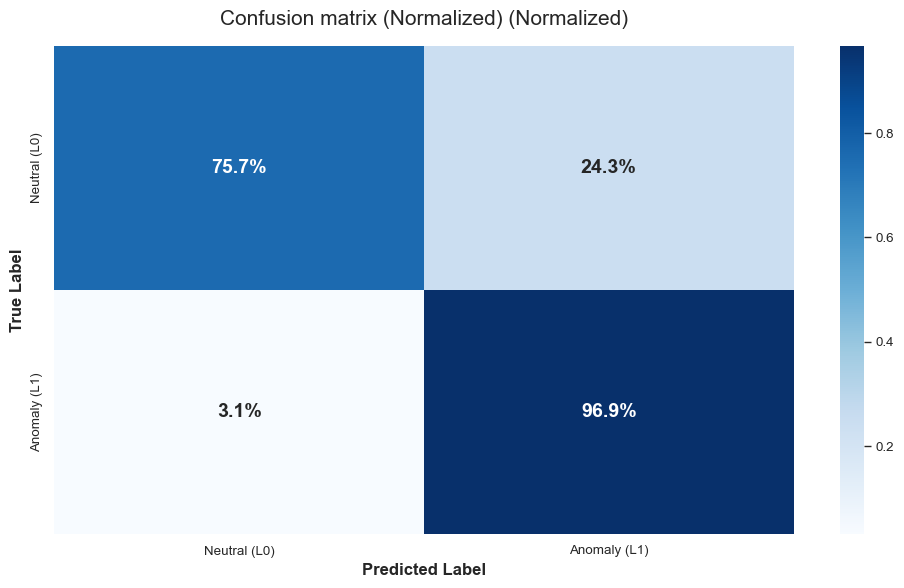

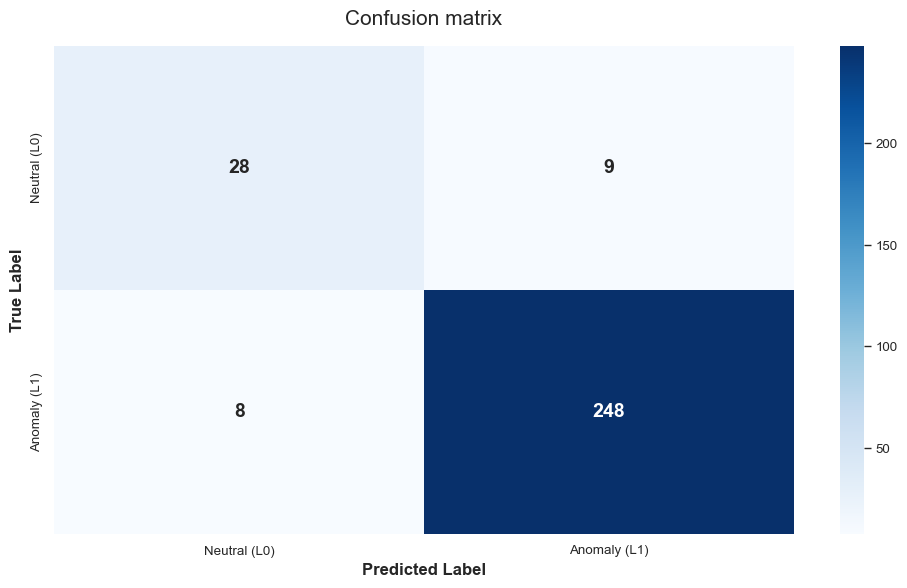

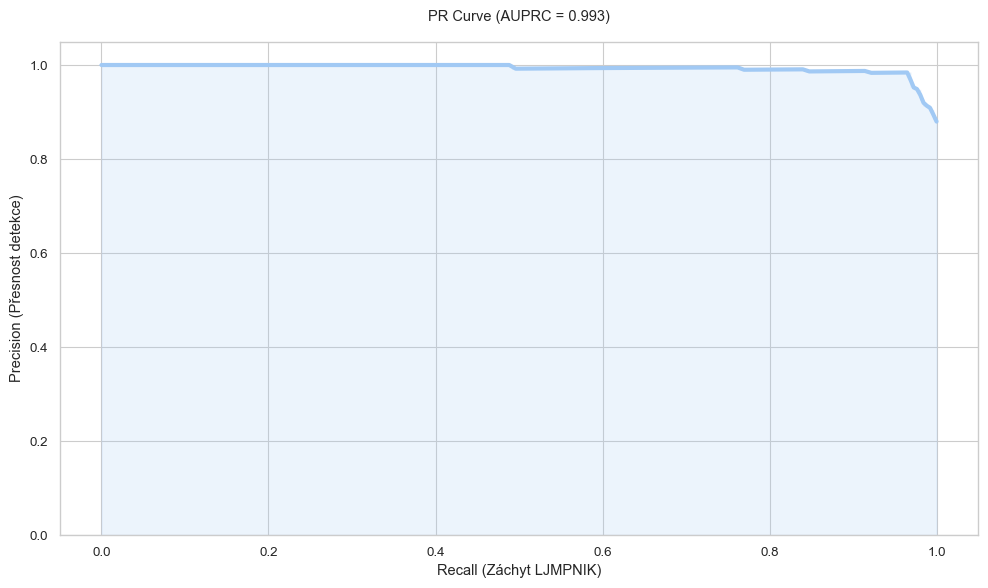

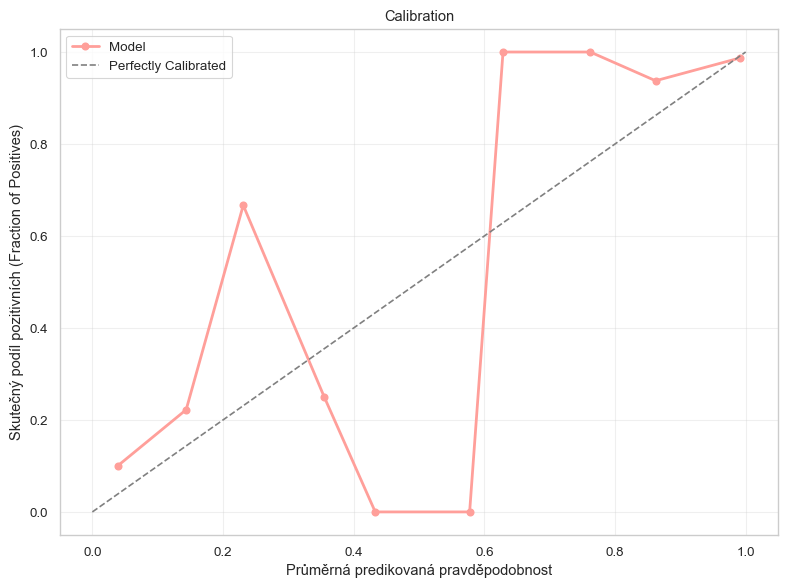

In [11]:
# 2. Vizualizace
# Používáme proměnné p_test (predikce) a s_test (skóre) z předchozí buňky
visualization.plot_confusion_matrix_heatmap(y_test_b, p_test, normalize=True, title="Confusion matrix (Normalized)")
visualization.plot_confusion_matrix_heatmap(y_test_b, p_test, normalize=False, title="Confusion matrix")
visualization.plot_pr_curve(y_test_b, s_test, title="PR Curve")
visualization.plot_model_calibration(y_test_b, s_test, title="Calibration")

#### 6. Projekce Embeddingů


2026-02-25 13:25:31,367 - INFO - 1️⃣ Computing PCA...
2026-02-25 13:25:31,398 - INFO - 2️⃣ Computing t-SNE...


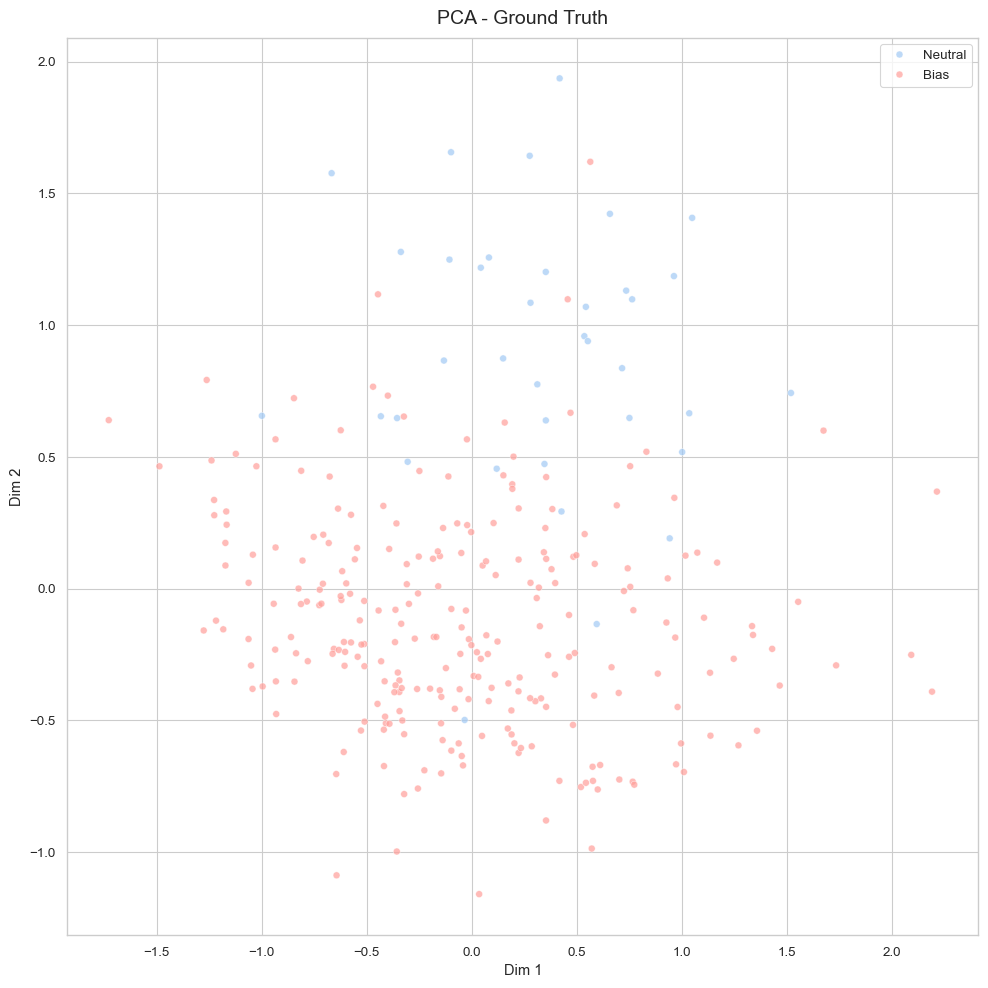

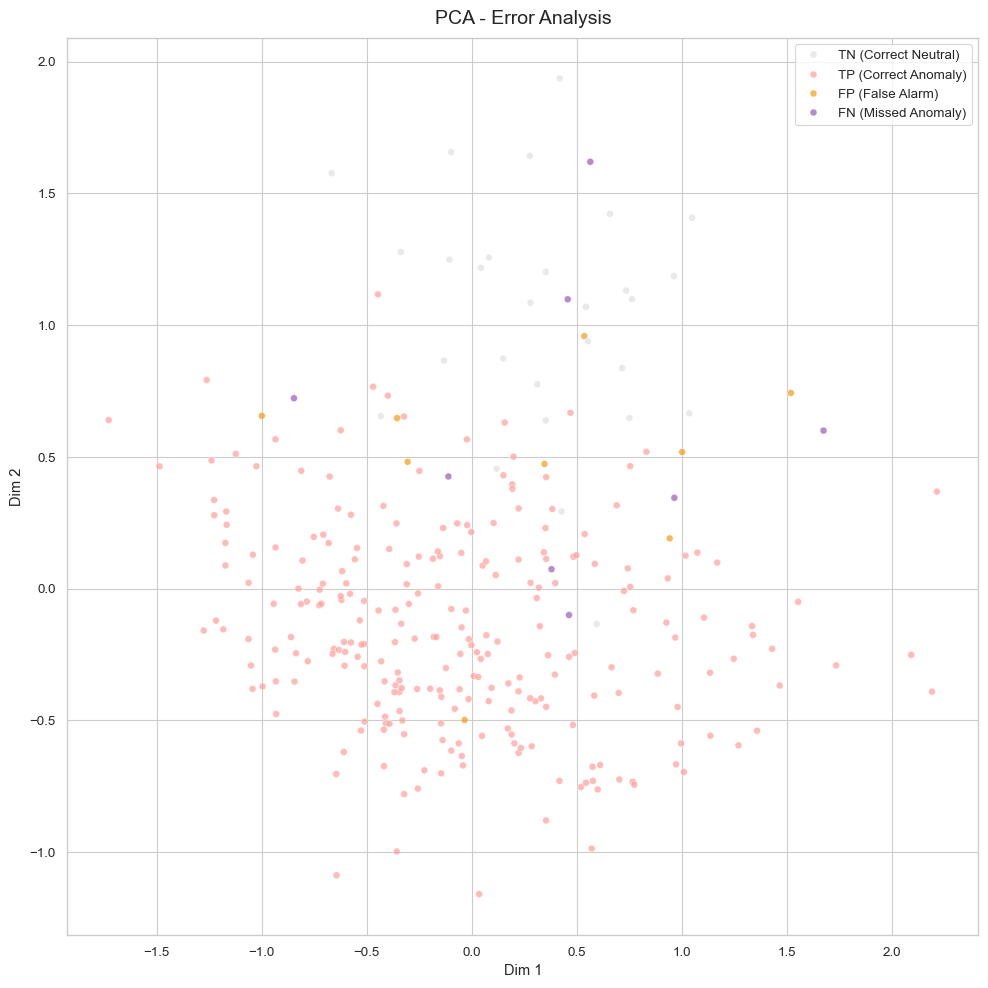

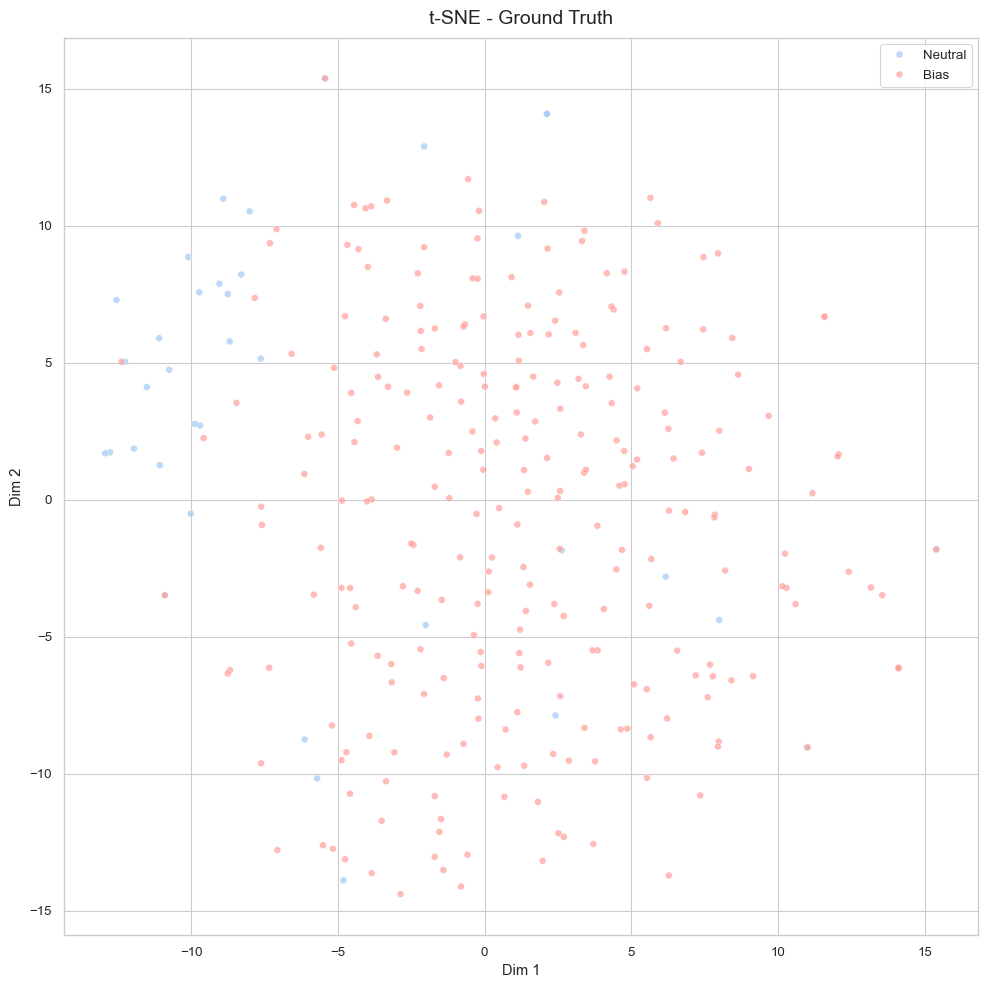

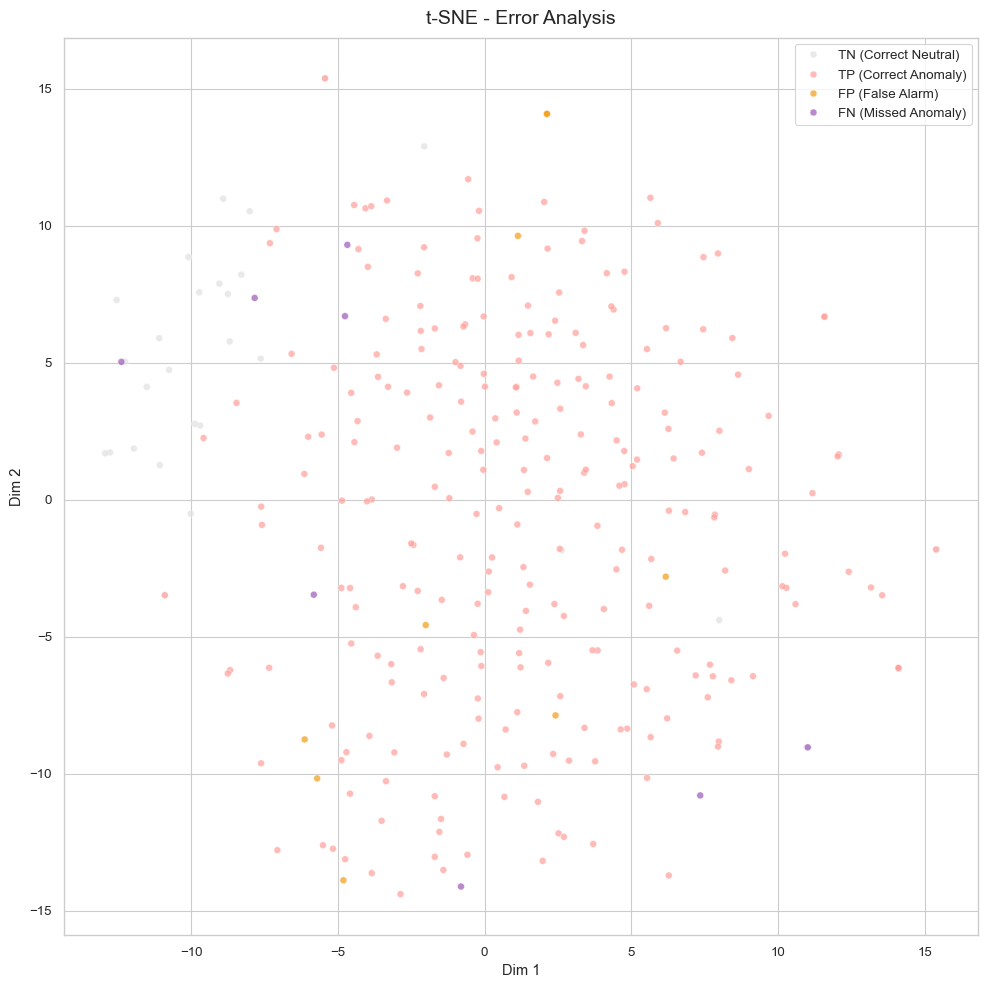

In [9]:
projs, idxs = visualization.compute_projections(X_test_b, methods=['PCA', 't-SNE'], random_state=42)
y_viz = y_test_b[idxs]
y_pred_viz = p_test[idxs]  # <-- ZDE byla změna z y_pred na p_test

for m, coords in projs.items():
    # GT
    visualization.plot_embedding_projection(
        coords, pd.Series(y_viz).map({0:'Neutral', 1:'Bias'}), 
        palette={'Neutral': config.COLORS['l0'], 'Bias': config.COLORS['l1']},
        title=f"{m} - Ground Truth"
    )
    # Errors
    visualization.plot_error_analysis_projection(
        coords, y_viz, y_pred_viz, method_name=m
    )

## 6. Qualitative Analysis (Error Analysis)

In [10]:
# =============================================================================
# 6. QUALITATIVE ANALYSIS (Detailní pohled na chyby)
# =============================================================================

# 1. Vezmeme existující metadata (obsahují document_id, sentence_id, text...)
# Použijeme .copy(), abychom neovlivnili původní data
df_qual = data_best['meta_test'].copy()

# 2. Přidáme predikce modelu (OPRAVENO: p_test a s_test)
df_qual['true_label'] = y_test_b
df_qual['pred_label'] = p_test
df_qual['anomaly_score'] = s_test

# 3. Určení kategorie (TP, TN, FP, FN)
conds = [
    (df_qual['true_label'] == 1) & (df_qual['pred_label'] == 1), # TP
    (df_qual['true_label'] == 0) & (df_qual['pred_label'] == 0), # TN
    (df_qual['true_label'] == 0) & (df_qual['pred_label'] == 1), # FP
    (df_qual['true_label'] == 1) & (df_qual['pred_label'] == 0)  # FN
]

df_qual['category'] = np.select(conds, ['TP', 'TN', 'FP', 'FN'], default='UNKNOWN')

# 4. Úklid sloupců (seřadíme je logicky)
# Definujeme preferované pořadí
preferred_cols = ['document_id', 'sentence_id', 'text', 'true_label', 'pred_label', 'anomaly_score', 'category']

# Vybereme jen ty, které v datech skutečně máme (aby to nepadalo, kdyby 'sentence_id' chybělo)
final_cols = [c for c in preferred_cols if c in df_qual.columns]

# Pokud zbyly nějaké další sloupce v metadatech, přidáme je nakonec
remaining_cols = [c for c in df_qual.columns if c not in final_cols]
df_qual = df_qual[final_cols + remaining_cols]

# 5. Výpis výsledků
print("\n❌ TOP 5 FP (Model vidí bias, kde není - False Alarm):")
display(df_qual[df_qual['category'] == 'FP'].sort_values('anomaly_score', ascending=False).head(5))

print("\n❌ TOP 5 FN (Model přehlédl bias - Missed Detection):")
display(df_qual[df_qual['category'] == 'FN'].sort_values('anomaly_score', ascending=True).head(5))

# 6. Uložení
save_path = config.RESULTS_DIR / "M2_S2_Qualitative_Analysis.csv"
df_qual.to_csv(save_path, index=False)
print(f"\n💾 Detailní analýza uložena: {save_path}")


❌ TOP 5 FP (Model vidí bias, kde není - False Alarm):


,document_id,sentence_id,text,true_label,pred_label,anomaly_score,category
108,gold_doc_0276,gold_doc_0276_target,"Poté , co v pondělí uvolnilo vstupenky na pros...",0,1,0.996372,FP
69,gold_doc_0230,gold_doc_0230_target,V norimberském procesu byla organizace SS ozna...,0,1,0.977411,FP
76,gold_doc_0237,gold_doc_0237_target,Nové varhany dostala katedrála za peníze z des...,0,1,0.954612,FP
162,gold_doc_0431,gold_doc_0431_target,Za jízdu na červenou hrozí vyšší pokuta .,0,1,0.862289,FP
24,gold_doc_0174,gold_doc_0174_target,Při nehodě došlo ke srážce tří osobních vozide...,0,1,0.593236,FP



❌ TOP 5 FN (Model přehlédl bias - Missed Detection):


,document_id,sentence_id,text,true_label,pred_label,anomaly_score,category
512,gold_doc_0505,gold_doc_0505_target,Omezení se dotkne linek jedoucích přes Karlák .,1,0,0.033336,FN
485,gold_doc_0475,gold_doc_0475_target,Policejní prezidium povolalo i těžkooděnce .,1,0,0.106020,FN
447,gold_doc_0387,gold_doc_0387_target,Od 50 předních českých autorů zahrnuje ta výst...,1,0,0.119617,FN
518,gold_doc_0517,gold_doc_0517_target,Hlídky byly posíleny zejména v nechvalně známé...,1,0,0.124384,FN
351,gold_doc_0242,gold_doc_0242_target,Město při plánování průmyslového parku o rozlo...,1,0,0.159793,FN



💾 Detailní analýza uložena: C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\results\M2_S2_Qualitative_Analysis.csv
